In [1]:
import pandas as pd

data = pd.read_csv('data/^NDX_raw_data.csv')
data.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup = data.iloc[3524:]

data = data.iloc[:3524]
data_copy = data.copy()

print('Data imported and copied.', flush=True)

Data imported and copied.


In [2]:
import numpy as np

## Creating sequences
def create_dataset(dataset, time_step=1, output_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-output_step):
        a = dataset[i:(i+time_step), 0]
        b = dataset[(i+time_step):(i+time_step)+output_step, 0]
        dataX.append(a)
        dataY.append(b)

    return np.array(dataX), np.array(dataY)

period = 60
trend_period = 14
rsi_period = 14
num_features = 1
input_period = 60
output_step = 7
units = 512

In [3]:
X, y = create_dataset(data[['close']].to_numpy(), time_step=period, output_step=output_step)

data_input = np.array([np.concatenate((X[i], y[i]), axis=0) for i in range(X.shape[0])])

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompositions = np.array([seasonal_decompose(data_input[i], model='additive', period=14) for i in range(data_input.shape[0])])
seasons = np.array([decompositions[i].seasonal for i in range(decompositions.shape[0])])

In [5]:
seasons_cropped = list()

# NO NEED TO CROP
for _season in seasons:
    seasons_cropped.append(_season)

seasons_cropped = np.array(seasons_cropped)

from sklearn.preprocessing import MinMaxScaler

scaler_seasonal = list(MinMaxScaler() for i in range(seasons_cropped.shape[0]))
seasons_scaled = list()

for i in range(seasons_cropped.shape[0]):
    seasons_scaled.append(scaler_seasonal[i].fit_transform(seasons_cropped[i].reshape(-1,1)))

seasons_scaled = np.array(seasons_scaled)

X_input = list()
y_input = list()

for season in seasons_scaled:
    X_input.append(season[:-y.shape[1]])
    y_input.append(season[-y.shape[1]:])

X_input = np.array(X_input)
y_input = np.array(y_input)

## Main model

In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Conv1D, AveragePooling1D, Flatten, Reshape, SimpleRNN, GRU, MaxPooling1D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Zeros

inputs = Input(shape=(input_period, num_features))

model_cnn = Sequential([
    Conv1D(filters=352, kernel_size=1, activation='relu'),
    Conv1D(filters=352, kernel_size=1, activation='relu'),
    MaxPooling1D(pool_size=3),
    Dense(units=128),
    Flatten()
    #Dense(units=output_step),
    #Reshape((output_step,1))
])

model_bilstm = Sequential([
    Bidirectional(LSTM(units=384, return_sequences=True, activation='tanh', recurrent_activation='sigmoid')),
    Dropout(0.2),
    Flatten()
    #Dense(units=output_step),
    #Reshape((output_step,1))
])

model_bigru = Sequential([
    Bidirectional(GRU(units=128, activation='tanh', return_sequences=True)),
    Dropout(0.4),
    Flatten()
])

model_multilayer_lstm = Sequential([
    LSTM(units=64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'),
    Dropout(0.2),
    LSTM(units=64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'),
    Flatten()
])

2024-05-31 06:33:34.245764: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 06:33:34.716966: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 06:33:34.717125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 06:33:34.783271: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-31 06:33:34.971491: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 06:33:37.174927: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

In [7]:
output_cnn = model_cnn(inputs)
output_bilstm = model_bilstm(inputs)
output_bigru = model_bigru(inputs)
output_multilayer_lstm = model_multilayer_lstm(inputs)

concatenated_outputs = concatenate([output_cnn, output_bilstm, output_bigru, output_multilayer_lstm])

main_model = Sequential([
    Input(shape=(concatenated_outputs.shape[1],)),
    Dense(units=output_step),
    Reshape((output_step,1))
])

final_output = main_model(concatenated_outputs)

functional_pipeline = Model(inputs=inputs, outputs=final_output)

In [8]:
# Compile the pipeline model
functional_pipeline.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='model_weights_6_5_topological/model_weights_epoch_{epoch:02d}.h5', 
                            save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the pipeline model
history = functional_pipeline.fit(X_input, y_input, epochs=150, batch_size=64, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Epoch 1/150


2024-05-29 16:46:42.896155: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 11796480 exceeds 10% of free system memory.
2024-05-29 16:46:42.917607: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 11796480 exceeds 10% of free system memory.
2024-05-29 16:46:43.156452: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17367040 exceeds 10% of free system memory.
2024-05-29 16:46:43.173752: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17367040 exceeds 10% of free system memory.
2024-05-29 16:46:43.289110: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 11796480 exceeds 10% of free system memory.


44/44 [==============================] - 66s 1s/step - loss: 0.1008 - accuracy: 0.1285 - val_loss: 0.0171 - val_accuracy: 0.1482
Epoch 2/150
44/44 [==============================] - 50s 1s/step - loss: 0.0122 - accuracy: 0.1511 - val_loss: 0.0059 - val_accuracy: 0.1482
Epoch 3/150
44/44 [==============================] - 55s 1s/step - loss: 0.0037 - accuracy: 0.1511 - val_loss: 0.0010 - val_accuracy: 0.1482
Epoch 4/150
44/44 [==============================] - 52s 1s/step - loss: 7.6239e-04 - accuracy: 0.1511 - val_loss: 8.2281e-05 - val_accuracy: 0.1482
Epoch 5/150
44/44 [==============================] - 49s 1s/step - loss: 4.3837e-04 - accuracy: 0.1511 - val_loss: 4.8516e-05 - val_accuracy: 0.1482
Epoch 6/150
44/44 [==============================] - 55s 1s/step - loss: 3.9106e-04 - accuracy: 0.1511 - val_loss: 5.3574e-05 - val_accuracy: 0.1482
Epoch 7/150
44/44 [==============================] - 50s 1s/step - loss: 3.8839e-04 - accuracy: 0.1511 - val_loss: 5.0198e-05 - val_accuracy: 

In [9]:
# Select the epoch
best_epoch = np.argmin(history.history['val_loss'])
best_epoch = best_epoch+1
print(f'best result is for epoch number {best_epoch}')

# Load the weights of the model at the chosen epoch
functional_pipeline.load_weights(f'model_weights_6_5_topological/model_weights_epoch_{best_epoch:02d}.h5')
print('Weigths for the best epoch has been loaded.')

best result is for epoch number 30
Weigths for the best epoch has been loaded.


In [8]:
best_epoch_backup = 30

# Load the weights of the model at the chosen epoch
functional_pipeline.load_weights(f'model_weights_6_5_topological/model_weights_epoch_{best_epoch_backup:02d}.h5')
print('Backup: Weigths for the best epoch has been loaded.')

Backup: Weigths for the best epoch has been loaded.


## data testing

In [9]:
data_backup = pd.read_csv('data/^NDX_raw_data.csv')
data_backup.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup_copy = data_backup.copy()

In [10]:
X_test, y_test = create_dataset(data_backup[['close']].to_numpy(), time_step=period, output_step=output_step)

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompositions_test = np.array([seasonal_decompose(X_test[i], model='additive', period=14) for i in range(X_test.shape[0])])
seasons_test = np.array([decompositions_test[i].seasonal for i in range(decompositions_test.shape[0])])

In [12]:
seasons_cropped_test = list()

for _season in seasons_test:
    seasons_cropped_test.append(_season)

seasons_cropped_test = np.array(seasons_cropped_test)

from sklearn.preprocessing import MinMaxScaler

scaler_seasonal_test = list(MinMaxScaler() for i in range(seasons_cropped_test.shape[0]))
seasons_scaled_test = list()

for i in range(seasons_cropped_test.shape[0]):
    seasons_scaled_test.append(scaler_seasonal_test[i].fit_transform(seasons_cropped_test[i].reshape(-1,1)))

seasons_scaled_test = np.array(seasons_scaled_test)

X_input_test = list()
#y_input = list()

for season in seasons_scaled_test:
    X_input_test.append(season)
    #y_input.append(lowess[-y.shape[1]:])

X_input_test = np.array(X_input_test)
#y_input = np.array(y_input)

In [13]:
season_predictions_test = list()

for j in range(X_input_test.shape[0]):
    if (j+1) % 100 == 0:
        print(j+1)
        
    season_predictions_test.append(
        scaler_seasonal_test[j].inverse_transform(
            functional_pipeline.predict(X_input_test[j].reshape(seasons_scaled_test[j].shape[1], input_period, num_features), verbose=0)[0].reshape(1,output_step)
        )
    )

season_predictions_test = np.array(season_predictions_test)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


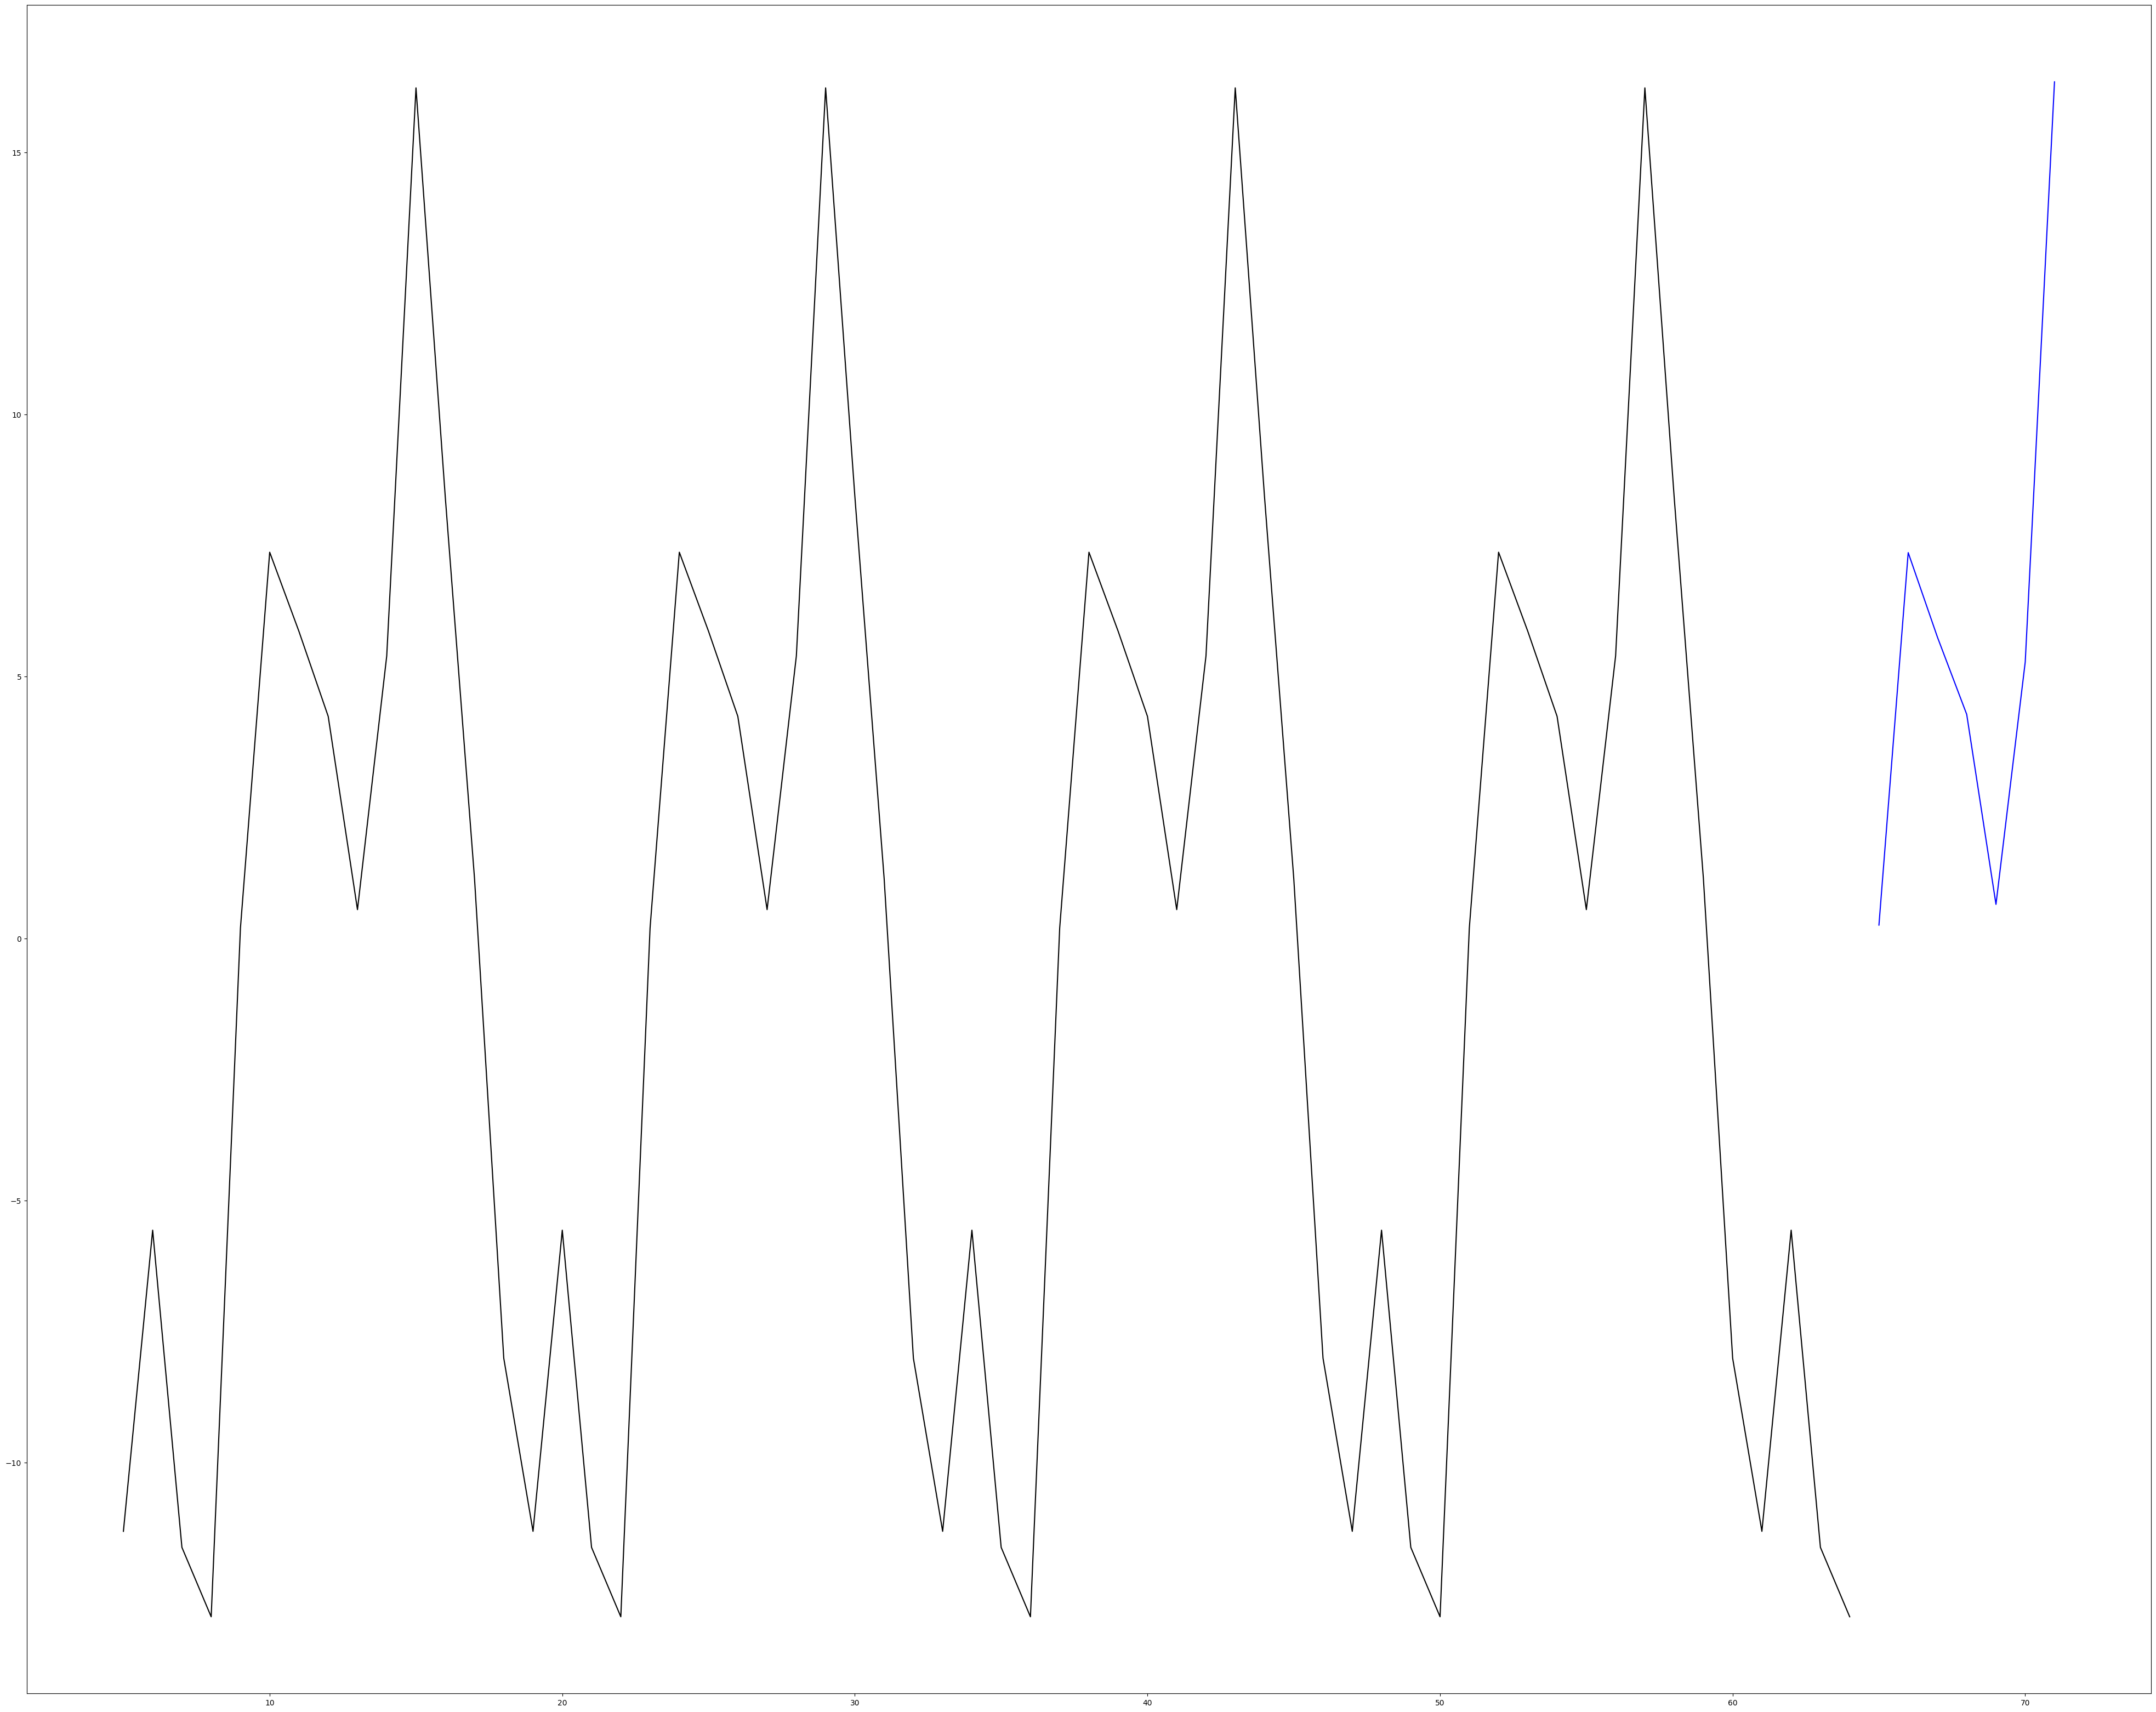

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

t = 5

plt.plot(data_backup.index[t+60:t+67], season_predictions_test[t][0], color='blue')
plt.plot(data_backup.index[t:t+60], seasons_cropped_test[t], color='black')
#plt.plot(data_backup.index[t:t+60], data_backup['close'].iloc[t:t+60], color='red')